# Detecting point cloud corners

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

import sklearn.linear_model as lm
from sklearn.cluster import KMeans
from skimage.transform import probabilistic_hough_line
from skimage import draw
import cv2

import warnings
warnings.filterwarnings("ignore")

## Importing data

- Data is in xyz format, which is not proprietary

In [7]:
df = pd.read_csv('a.xyz', sep=' ')
df = df.drop(df.columns[3:], axis=1)
mat = df.to_numpy()
mat, df

(array([[ 1.07755468,  0.95502702, -0.53163028],
        [ 1.08658857,  0.93398298, -0.51134588],
        [ 1.07552482,  0.95006177, -0.53640623],
        ...,
        [-1.77976101, -1.53270584,  0.53316433],
        [-1.77534856, -1.53509981,  0.54452064],
        [-1.76862453, -1.54747089,  0.5696933 ]]),
                #  Exported        By
 0       1.077555  0.955027 -0.531630
 1       1.086589  0.933983 -0.511346
 2       1.075525  0.950062 -0.536406
 3       1.082401  0.912204 -0.521457
 4       1.081830  0.918058 -0.522638
 ...          ...       ...       ...
 238232 -1.776589 -1.540429  0.546742
 238233 -1.767446 -1.551771  0.576029
 238234 -1.779761 -1.532706  0.533164
 238235 -1.775349 -1.535100  0.544521
 238236 -1.768625 -1.547471  0.569693
 
 [238237 rows x 3 columns])

## Visualising 3d point-cloud data

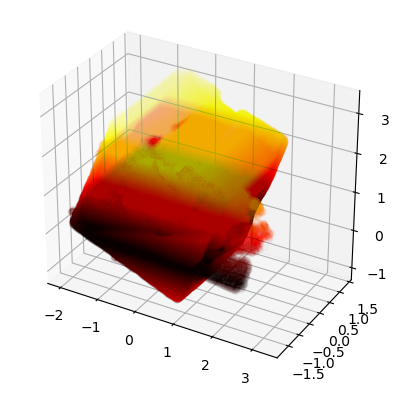

In [8]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', adjustable='box')
plt.show()

## Profiling points on the ceiling

- Done by iterating in a specified direction
- All points 

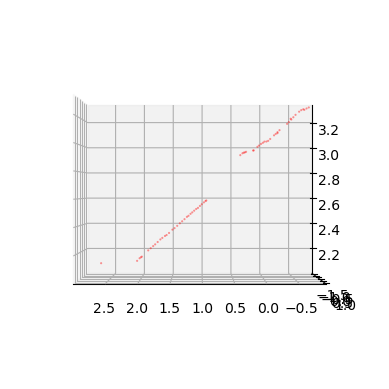

In [44]:
def find_ceiling(col, ssize):
    indices = np.zeros((1, 3))
    end = len(df[col]) // ssize
    ordf = df.sort_values(by=[col])
    for i in reversed(range(end)):
        temp = ordf[i*ssize:(i+1)*ssize]
        idx = temp[['By']].idxmax()
        current = df.iloc[idx].to_numpy()[0].copy()
        if np.max(indices[:,2]) < current[2]:
            indices = np.vstack((indices,current))
    indices = indices[1:,:]
    return indices

indices = find_ceiling('#', 2000)
# ind2 = find_ceiling('Exported', 250)
# indices = np.vstack((ind1, ind2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:,0], indices[:,1], indices[:,2], color='r', s=0.3, alpha=0.4)
ax.view_init(elev=0, azim=90)
plt.show()

Equation: 0 = 3.00 + -0.43x + -0.01y - z


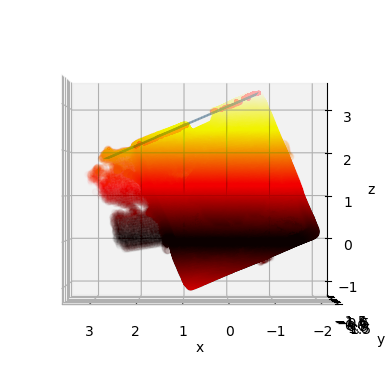

In [45]:
X_train = indices[:, :2]
y_train = indices[:, 2]
X_test = np.random.rand(200).reshape(100,2)*60

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

model = lm.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xrange = indices[:,0]
yrange = indices[:,1]

x = np.linspace(np.min(xrange), np.max(xrange))
y = np.linspace(np.min(yrange), np.max(yrange))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(x, (len(x),1))
ys = np.tile(y, (len(y),1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: 0 = {:.2f} + {:.2f}x + {:.2f}y - z".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', 'box')
ax.view_init(elev=0, azim=90)
plt.show()

In [46]:
def create_rot_mat(coefs):
    norm = -np.array([coefs[0], coefs[1], -1])
    norm = norm / np.linalg.norm(norm)
    basis_x = np.array([1, 0, 0])
    axis = np.cross(norm, basis_x)
    axis = axis / np.linalg.norm(axis)
    angle = -np.arccos(np.dot(norm, basis_x))
    C = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    return np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)

rot_mat = create_rot_mat(coefs)
inv_rot = np.linalg.inv(rot_mat)
mat2d = np.dot(inv_rot, mat.T).T

ceil = mat2d[mat2d[:, 2].argsort()[:80000]][:,:2]

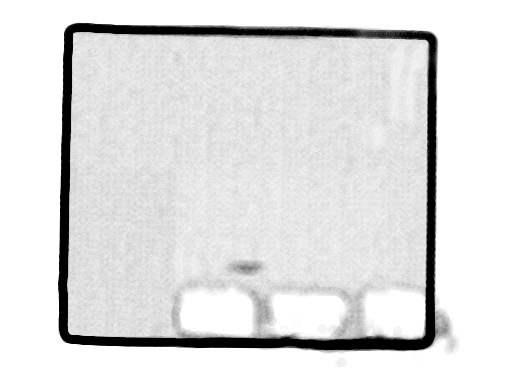

In [47]:
%matplotlib inline

plt.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.002)
plt.axis('equal')
plt.axis('off')
plt.savefig('._.png')

In [39]:
fig, ax = plt.subplots(1)
ax.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.002)

# ax.set_xlim(ceil[:,0].min(), ceil[:,0].max())
# ax.set_ylim(ceil[:,1].min(), ceil[:,1].max())
plt.axis('off')
fig.canvas.draw_idle()
plt.ioff()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
data

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

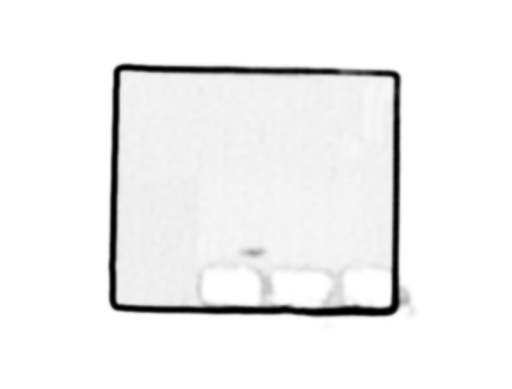

In [48]:
image = cv2.imread('._.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)
sigma = np.std(blur)
mean = np.mean(blur)
lower = int(max(0, (mean - sigma)))
upper = int(min(255, (mean + sigma)))

edge = cv2.Canny(blur, lower, upper)
# edge = np.uint8((255 - cv2.Canny(gray, 200, 300, apertureSize=3)) // 255)
plt.imshow(blur, cmap='Greys_r')
plt.axis('off')
plt.show()

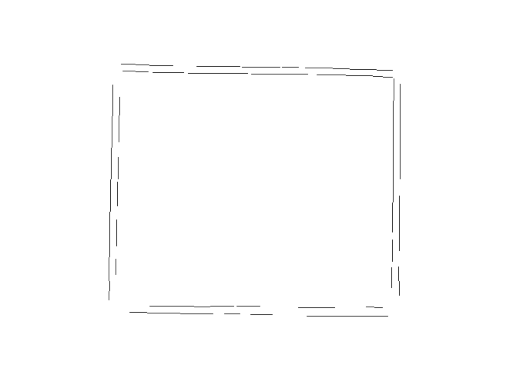

52


In [49]:
lines = probabilistic_hough_line(edge, threshold=2, line_length=20, line_gap=1)
restored = np.zeros_like(edge, dtype=np.uint8)
for line in lines:
    p0, p1 = line
    rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
    restored[rr, cc] += 1
plt.imshow(restored, cmap='Greys')
plt.axis('off')
plt.show()

length = len(lines)
starts = np.array([[i[0][0],i[0][1]] for i in lines])
grad = np.array([[np.abs(i[1][0]-i[0][0]),np.abs(i[1][1]-i[0][1])] for i in lines])
norms = np.sqrt(grad[:,0]**2 + grad[:,1]**2)[:, np.newaxis]
norms = np.hstack((norms, norms)) + 0.001
grad = grad / norms
print(length)

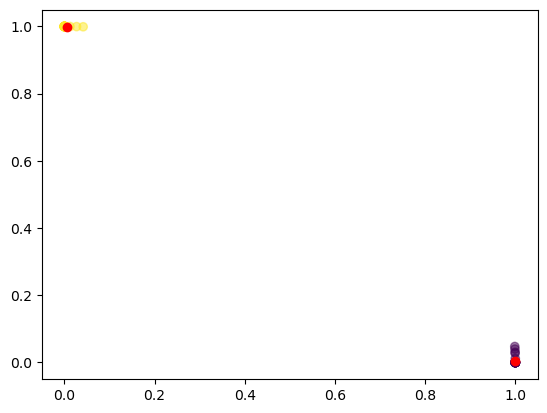

In [50]:
km = KMeans(n_clusters=2)
km.fit(grad)
km.predict(grad)
labels = km.labels_

class_grad = np.hstack((grad, labels[:, np.newaxis]))
class_size = np.hstack((starts, labels[:, np.newaxis]))

b0 = np.mean(class_grad[class_grad[:,2] == 0.][:,:2], axis=0)
# b1 = np.mean(class_grad[class_grad[:,2] == 1.][:,:2], axis=0)
b1 = np.array([b0[1], b0[0]])

plt.scatter(grad[:,0], grad[:,1], c=labels, alpha=0.5)
plt.scatter(b0[0], b0[1], c='r')
plt.scatter(b1[0], b1[1], c='r')
plt.show()

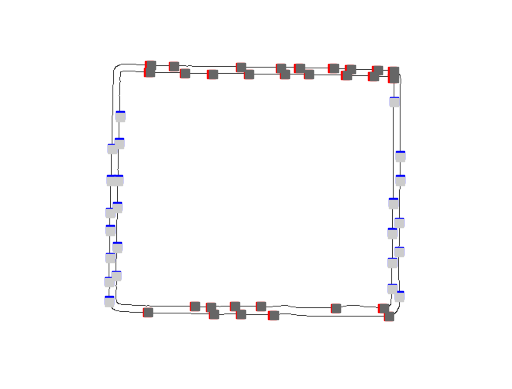

In [51]:
starts0 = class_size[class_size[:,2] == 0.][:,:2]
starts1 = class_size[class_size[:,2] == 1.][:,:2]
shifted0 = starts0 + np.tile(b0, (len(starts0), 1)) * 2
shifted1 = starts1 + np.tile(b1, (len(starts1), 1)) * 2
plt.scatter(starts0[:,0], starts0[:,1], c='r', marker='s')
plt.scatter(starts1[:,0], starts1[:,1], c='b', marker='s')
plt.scatter(shifted0[:,0], shifted0[:,1], c='0.4', marker='s')
plt.scatter(shifted1[:,0], shifted1[:,1], c='0.8', marker='s')
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()

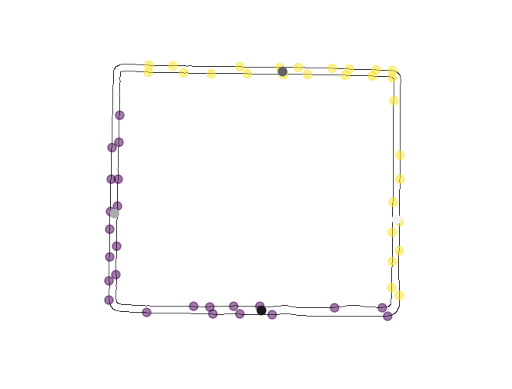

In [52]:
km = KMeans(n_clusters=2)
km.fit(starts0)
km.predict(starts0)
label0 = km.labels_

km = KMeans(n_clusters=2)
km.fit(starts1)
km.predict(starts1)
label1 = km.labels_

starts0 = np.hstack((starts0, label0[:, np.newaxis]))
starts1 = np.hstack((starts1, label1[:, np.newaxis]))

s00 = np.mean(starts0[starts0[:,2] == 0.][:,:2], axis=0)
s01 = np.mean(starts0[starts0[:,2] == 1.][:,:2], axis=0)


s10 = np.mean(starts1[starts1[:,2] == 0.][:,:2], axis=0)
s11 = np.mean(starts1[starts1[:,2] == 1.][:,:2], axis=0)

plt.scatter(starts0[:,0], starts0[:,1], c=label0, alpha=0.5)
plt.scatter(starts1[:,0], starts1[:,1], c=label1, alpha=0.5)

for i, j in enumerate([s00, s01, s10, s11]):
    plt.scatter(j[0], j[1], c=f'{i/3.5+0.1}')
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()

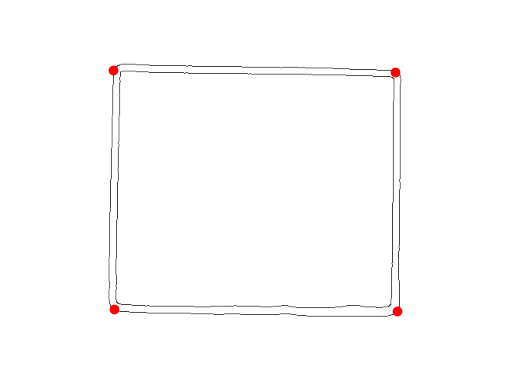

array([[ 56.30507248, 310.61764205],
       [423.02199418, 312.60762542],
       [ 54.61951093,   0.        ],
       [421.33643263,   1.98998337]])

In [57]:
points = np.zeros((1, 2))
a = np.vstack((b0, -b1)).T
for i0 in [s00, s01]:
    for i1 in [s10, s11]:
        b = i0[:, np.newaxis] - i1[:, np.newaxis]
        x = np.linalg.solve(a, b)
        x = i1 - x[1] * b1
        points = np.vstack((points, x[np.newaxis, :]))
points = points[1:, :]
plt.imshow(edge, cmap='Greys')
plt.scatter(points[:,0], points[:,1], c='r')
plt.axis('off')
plt.show()
points - points.min()

In [93]:
ceil[:,0].max(),ceil[:,0].min(),ceil[:,1].max(),ceil[:,1].min()

ssize = 250
m = ceil[:,1].min()
diff = (ceil[:,1].max() - m) / ssize
for i in range(ssize):
    temp = ceil[:,0][np.logical_and(ceil[:,1] > (i*diff + m),ceil[:,1] < (i+1)*((i+1)*diff + m))]

In [70]:
xmin_c, xmax_c = np.min(ceil[:, 0]), np.max(ceil[:, 0])
ymin_c, ymax_c = np.min(ceil[:, 1]), np.max(ceil[:, 1])
shape_c = xmax_c - xmin_c, ymax_c - ymin_c

xmin_s, xmax_s = np.min(starts[:, 0]), np.max(starts[:, 0])
ymin_s, ymax_s = np.min(starts[:, 1]), np.max(starts[:, 1])
shape_s = xmax_s - xmin_s, ymax_s - ymin_s

factor_x = shape_s[0] / shape_c[0]
factor_y = shape_s[1] / shape_c[1]
factor = np.mean((factor_y, factor_x))
adj = 0.98

corners = (points - points.min()) / factor
# plt.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.002)
# plt.scatter(corners[:,0], corners[:, 1], color='r')
# plt.axis('equal')
flat = corners.flatten()
matr = np.vstack((flat, np.zeros_like(flat))).T

km = KMeans(n_clusters=4)
km.fit(matr)
km.predict(matr)
lab = km.labels_

d = {}
for i in range(4):
    d[i] = np.min(flat[lab == i])
for i, j in enumerate(lab):
    flat[i] = d[j]
flat.reshape((4,2))

array([[0.51877664, 2.95024937],
       [4.00185751, 2.95024937],
       [0.51877664, 0.        ],
       [4.00185751, 0.        ]])

In [61]:
corners

array([[0.53478612, 2.95024937],
       [4.01786699, 2.96915025],
       [0.51877664, 0.        ],
       [4.00185751, 0.01890088]])